In [1]:
import numpy as np
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from skimage.metrics import structural_similarity as ssim


In [2]:
base = Path("/gpfs/commons/home/svaidyanathan/istarc")  # adjust if needed

# Heat-diffused "ground truth" data
heat_dir = base / "data" / "heat_diffused_data_3.5"
npy_path = heat_dir / "visium_mouse_brain_pixel_gene_maps.npy"
genes_txt_path = heat_dir / "visium_mouse_brain_pixel_gene_maps_genes.txt"


In [3]:
model_configs = [
    {
        "key": "iSTAR (unmodified)",
        "display_name": "Without CT Proportions",
        "pickle_dir": base / "istar" / "data" / "bad_mask" / "visium_mouse_brain" / "cnts-super",
    },
    {
        "key": "iSTAR with Starfysh CT Supervision",
        "display_name": "With CT Proportions",
        "pickle_dir": base / "istar" / "data" / "bad_mask" / "visium_mouse_brain_ct" / "cnts-super",
    },
    {
        "key": "iSTAR with Starfysh CT Supervision and Fake Heat-Diffused Spots",
        "display_name": "With CT Proportions + Fake Spots from Heat Diff",
        "pickle_dir": base / "istar" / "data" / "bad_mask" / "visium_mouse_brain_ct_hd_3.5_gaussian_weight_0.1" / "cnts-super",
    },
]

# Metric parameters
confident_frac = 0.3      # fraction of highest heat diffusion pixels
topk_fraction = 0.05      # top-k% for Jaccard/Dice
random_seed = 42

# Plotting / sampling parameters
n_genes_for_bar = 15          # per-gene bar chart
n_genes_for_example_plots = 5 # multi-panel images


In [4]:
ge_pixel_maps = np.load(npy_path)
print("ge_pixel_maps shape:", ge_pixel_maps.shape)

with open(genes_txt_path) as f:
    genes_for_pixels = [line.strip() for line in f]

print(f"Total genes in heat-diffused maps: {len(genes_for_pixels)}")
gene_to_idx = {g: i for i, g in enumerate(genes_for_pixels)}

ge_pixel_maps shape: (912, 880, 1000)
Total genes in heat-diffused maps: 1000


In [5]:
# %%
# Utility functions

def load_model_gene(pickle_dir: Path, gene: str):
    """Load a gene's pickle from a given model folder."""
    p = pickle_dir / f"{gene}.pickle"
    with open(p, "rb") as f:
        arr = pickle.load(f)
    arr = np.asarray(arr)
    return arr


def min_max_norm(x):
    x = x.astype(float)
    x_min = np.nanmin(x)
    x_max = np.nanmax(x)
    rng = x_max - x_min
    if rng <= 0:
        return np.zeros_like(x)
    return (x - x_min) / rng


def metrics_on_confident_region(heat_map, model_map, frac=0.3):
    """
    Compare only in the top `frac` fraction of heat_map pixels
    (where diffusion is strongest). Returns (Spearman, SSIM).
    """
    h_flat = heat_map.ravel()

    nz = h_flat[h_flat > 0]
    if nz.size == 0:
        return np.nan, np.nan

    thr = np.quantile(nz, 1 - frac)
    mask = heat_map >= thr

    h_sel = heat_map[mask]
    m_sel = model_map[mask]

    # Spearman on confident region
    rho, _ = spearmanr(h_sel, m_sel)

    # SSIM on masked region: zero out everything else
    h_norm = min_max_norm(heat_map)
    m_norm = min_max_norm(model_map)
    h_masked = np.where(mask, h_norm, 0)
    m_masked = np.where(mask, m_norm, 0)
    ssim_val = ssim(h_masked, m_masked, data_range=1.0)

    return rho, ssim_val


def topk_overlap(heat_map, model_map, k=0.05):
    """
    Jaccard/Dice overlap of top-k% high-expression pixels
    between model output and pixel-level heat-diffused data.
    """
    h_flat = heat_map.ravel()
    m_flat = model_map.ravel()

    h_thr = np.quantile(h_flat, 1 - k)
    m_thr = np.quantile(m_flat, 1 - k)

    h_top = heat_map >= h_thr
    m_top = model_map >= m_thr

    inter = np.logical_and(h_top, m_top).sum()
    union = np.logical_or(h_top, m_top).sum()
    jaccard = inter / union if union > 0 else np.nan

    denom = h_top.sum() + m_top.sum()
    dice = 2 * inter / denom if denom > 0 else np.nan

    return jaccard, dice


In [6]:

metrics = {
    cfg["key"]: {} for cfg in model_configs
}  # metrics[model_key][gene] = dict of scores

for gene in genes_for_pixels:
    idx = gene_to_idx[gene]
    heat_map = ge_pixel_maps[:, :, idx]

    for cfg in model_configs:
        mkey = cfg["key"]
        pickle_dir = cfg["pickle_dir"]

        # Skip if already computed (in case of duplicates)
        if gene in metrics[mkey]:
            continue

        try:
            model_map = load_model_gene(pickle_dir, gene)
        except FileNotFoundError:
            # silently skip, or print if you want:
            # print(f"{gene} – {cfg['display_name']} pickle not found")
            continue

        rho_conf, ssim_conf = metrics_on_confident_region(
            heat_map, model_map, frac=confident_frac
        )
        jacc, dice = topk_overlap(
            heat_map, model_map, k=topk_fraction
        )

        metrics[mkey][gene] = {
            "rho_conf": rho_conf,
            "ssim_conf": ssim_conf,
            "jaccard": jacc,
            "dice": dice,
        }

# Simple summary: how many genes per model had valid pickles
for cfg in model_configs:
    mkey = cfg["key"]
    print(f"{cfg['display_name']}: metrics for {len(metrics[mkey])} genes")

KeyboardInterrupt: 

In [9]:

rng = np.random.default_rng(random_seed)

# Genes available in ALL models (for clean side-by-side comparison)
genes_per_model = [set(metrics[cfg["key"]].keys()) for cfg in model_configs]
if genes_per_model:
    common_genes = set.intersection(*genes_per_model)
else:
    common_genes = set()

common_genes = sorted(common_genes)

if not common_genes:
    raise RuntimeError("No genes found that have pickles in all configured model folders.")

# Subset for per-gene bar plots
if len(common_genes) > n_genes_for_bar:
    bar_genes = list(rng.choice(common_genes, size=n_genes_for_bar, replace=False))
else:
    bar_genes = common_genes

bar_genes = sorted(bar_genes)
print(f"Using {len(bar_genes)} genes for per-gene bar chart.")

# Subset for example multi-panel images
if len(common_genes) > n_genes_for_example_plots:
    example_genes = list(rng.choice(common_genes, size=n_genes_for_example_plots, replace=False))
else:
    example_genes = common_genes

example_genes = sorted(example_genes)
print(f"Using {len(example_genes)} genes for example plots: {example_genes}")

Using 15 genes for per-gene bar chart.
Using 5 genes for example plots: [np.str_('Bcas1'), np.str_('Ddn'), np.str_('Kcnh3'), np.str_('Kcnma1'), np.str_('Ndfip2')]


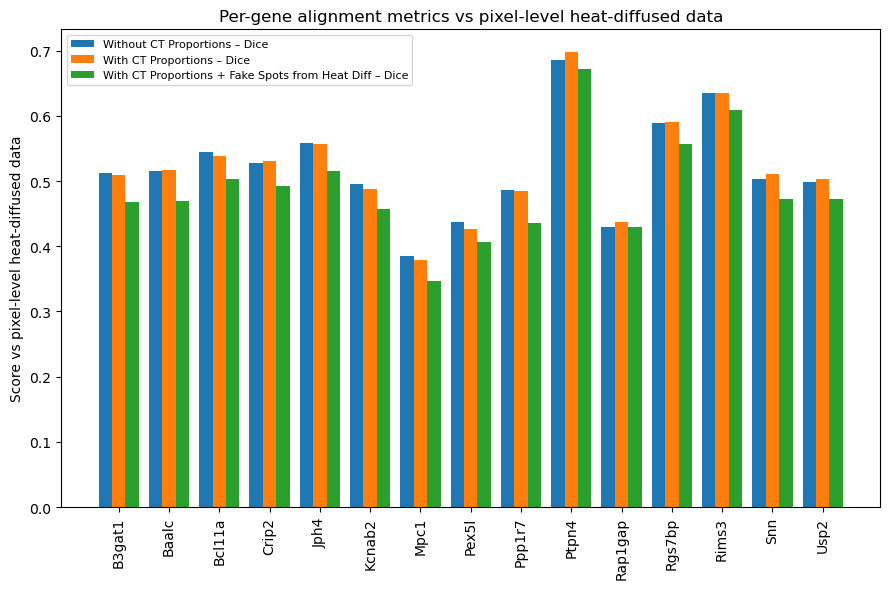

In [12]:
# Per-gene bar chart: Jaccard and Dice vs pixel-level heat-diffused data
# One "column" per gene, 2 metrics per model.

model_keys = [cfg["key"] for cfg in model_configs]
model_labels = {cfg["key"]: cfg["display_name"] for cfg in model_configs}

# Flatten combinations (model, metric)
metric_names = ["dice"]
metric_labels = {"dice": "Dice"}

combos = [(mkey, mname) for mkey in model_keys for mname in metric_names]
n_combos = len(combos)

x = np.arange(len(bar_genes))
width = 0.8 / n_combos  # keep total width ~0.8 per gene

fig, ax = plt.subplots(figsize=(max(8, len(bar_genes) * 0.6), 6))

for j, (mkey, mname) in enumerate(combos):
    heights = []
    for gene in bar_genes:
        val = metrics[mkey][gene][mname]
        heights.append(val)

    # Offset around each gene position
    offsets = (j - (n_combos - 1) / 2) * width
    ax.bar(x + offsets, heights, width, label=f"{model_labels[mkey]} – {metric_labels[mname]}")

ax.set_xticks(x)
ax.set_xticklabels(bar_genes, rotation=90)
ax.set_ylabel("Score vs pixel-level heat-diffused data")
ax.set_title("Per-gene alignment metrics vs pixel-level heat-diffused data")
ax.legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()

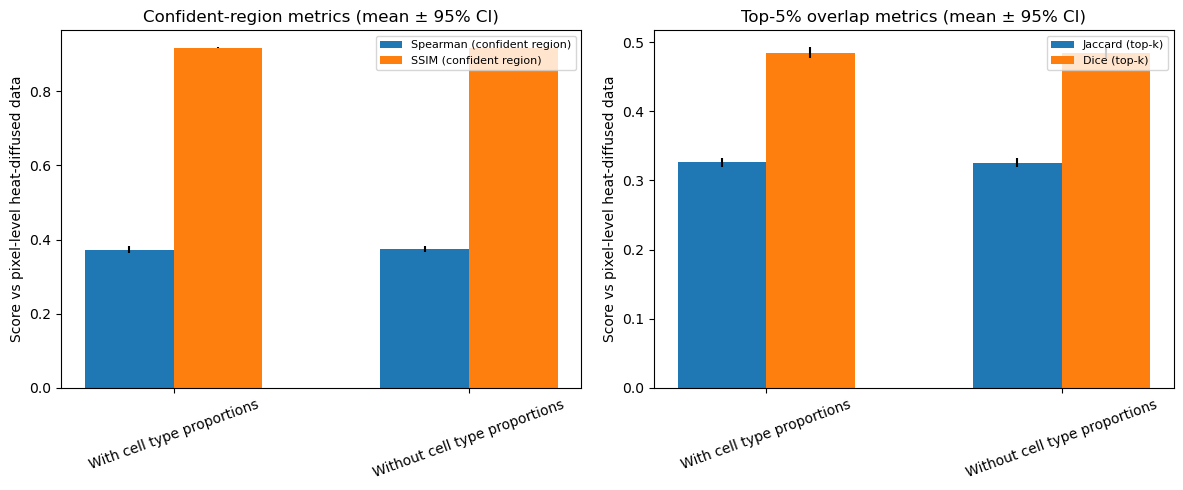

In [9]:
def mean_and_ci(values, ci=0.95):
    """Return (mean, half-width of CI) using normal approx."""
    vals = np.array([v for v in values if not np.isnan(v)])
    if vals.size == 0:
        return np.nan, 0.0
    mean = vals.mean()
    if vals.size == 1:
        return mean, 0.0
    std = vals.std(ddof=1)
    z = 1.96  # ~95% CI
    half_width = z * std / np.sqrt(vals.size)
    return mean, half_width


summary_metrics = {}
for cfg in model_configs:
    mkey = cfg["key"]
    mgenes = metrics[mkey]
    rho_list = [mgenes[g]["rho_conf"] for g in mgenes]
    ssim_list = [mgenes[g]["ssim_conf"] for g in mgenes]
    jacc_list = [mgenes[g]["jaccard"] for g in mgenes]
    dice_list = [mgenes[g]["dice"] for g in mgenes]

    summary_metrics[mkey] = {
        "rho_conf": mean_and_ci(rho_list),
        "ssim_conf": mean_and_ci(ssim_list),
        "jaccard": mean_and_ci(jacc_list),
        "dice": mean_and_ci(dice_list),
    }

# Plot: two panels (confident-region metrics, top-k overlap metrics)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel 1: confident-region Spearman and SSIM
ax = axes[0]
metrics_cr = ["rho_conf", "ssim_conf"]
labels_cr = {"rho_conf": "Spearman (confident region)",
             "ssim_conf": "SSIM (confident region)"}

for i, mname in enumerate(metrics_cr):
    heights = []
    errors = []
    for cfg in model_configs:
        mkey = cfg["key"]
        mean, hw = summary_metrics[mkey][mname]
        heights.append(mean)
        errors.append(hw)
    positions = np.arange(len(model_configs)) + i * 0.3
    ax.bar(positions, heights, yerr=errors, width=0.3, label=labels_cr[mname])

ax.set_xticks(np.arange(len(model_configs)) + 0.3 / 2)
ax.set_xticklabels([cfg["display_name"] for cfg in model_configs], rotation=20)
ax.set_ylabel("Score vs pixel-level heat-diffused data")
ax.set_title("Confident-region metrics (mean ± 95% CI)")
ax.legend(fontsize=8)

# Panel 2: top-k Jaccard and Dice
ax = axes[1]
metrics_topk = ["jaccard", "dice"]
labels_topk = {"jaccard": "Jaccard (top-k)",
               "dice": "Dice (top-k)"}

for i, mname in enumerate(metrics_topk):
    heights = []
    errors = []
    for cfg in model_configs:
        mkey = cfg["key"]
        mean, hw = summary_metrics[mkey][mname]
        heights.append(mean)
        errors.append(hw)
    positions = np.arange(len(model_configs)) + i * 0.3
    ax.bar(positions, heights, yerr=errors, width=0.3, label=labels_topk[mname])

ax.set_xticks(np.arange(len(model_configs)) + 0.3 / 2)
ax.set_xticklabels([cfg["display_name"] for cfg in model_configs], rotation=20)
ax.set_ylabel("Score vs pixel-level heat-diffused data")
ax.set_title(f"Top-{int(topk_fraction*100)}% overlap metrics (mean ± 95% CI)")
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [7]:
def plot_with_contours_multi(gene, frac=0.3):
    idx = gene_to_idx[gene]
    heat_map = ge_pixel_maps[:, :, idx]

    # mask thresholding still computed if you want it later; otherwise you can delete this block
    nz = heat_map[heat_map > 0]
    thr = np.quantile(nz, 1 - frac) if nz.size > 0 else np.inf
    mask = heat_map >= thr  # unused now

    # Load model outputs (only those that have pickles for this gene)
    model_maps = []
    valid_cfgs = []
    for cfg in model_configs:
        try:
            arr = load_model_gene(cfg["pickle_dir"], gene)
            model_maps.append(arr)
            valid_cfgs.append(cfg)
        except FileNotFoundError:
            continue

    if not model_maps:
        print(f"{gene}: no model pickle found in any folder.")
        return

    # Compute global color limits across heat_map and all model maps
    all_maps = [heat_map] + model_maps
    vmin = min(np.nanmin(m) for m in all_maps)
    vmax = max(np.nanmax(m) for m in all_maps)
    if vmin == vmax:
        vmin -= 1e-6
        vmax += 1e-6

    n_models = len(valid_cfgs)
    n_cols = 1 + n_models

    fig, axes = plt.subplots(1, n_cols, figsize=(4 * n_cols, 4))

    # If there's only one model, axes isn't a list, so normalize it
    if n_cols == 1:
        axes = [axes]
    else:
        axes = list(axes)

    # Column 0: heat diffusion
    ax0 = axes[0]
    im0 = ax0.imshow(heat_map, vmin=vmin, vmax=vmax)
    ax0.set_title(f"{gene} – pixel-level heat-diffused data")
    ax0.axis("off")
    fig.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)

    # One column per model
    for i, (cfg, model_map) in enumerate(zip(valid_cfgs, model_maps), start=1):
        ax_m = axes[i]
        im_m = ax_m.imshow(model_map, vmin=vmin, vmax=vmax)
        ax_m.set_title(f"{gene} – {cfg['display_name']}")
        ax_m.axis("off")
        fig.colorbar(im_m, ax=ax_m, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


In [ ]:
# %%
# Example multi-panel plots for a small subset of genes

for gene in example_genes:
    print(f"Plotting multi-panel visualization for {gene}")
    plot_with_contours_multi(gene, frac=confident_frac)

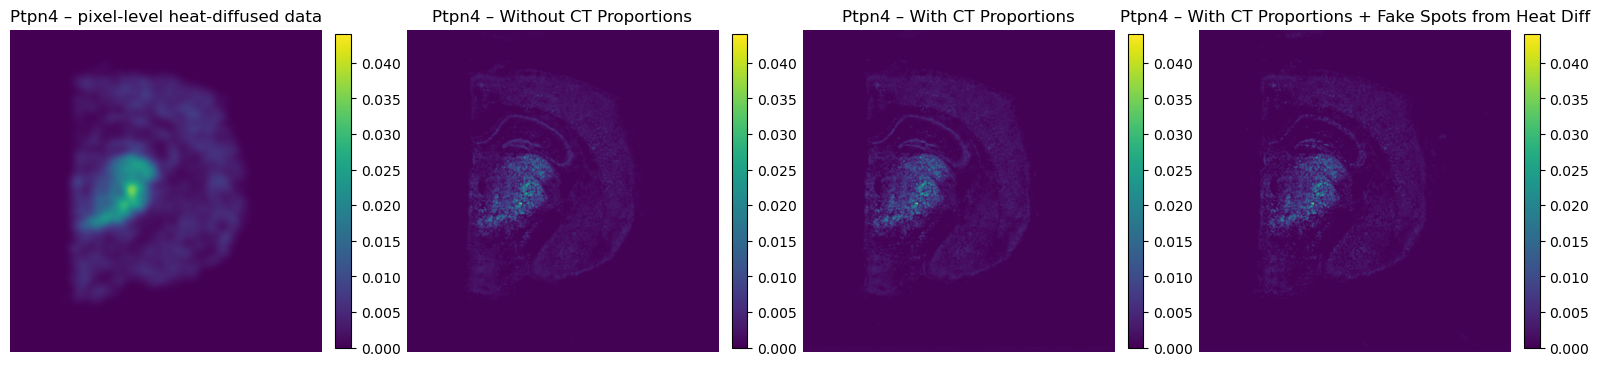

In [15]:
plot_with_contours_multi("Ptpn4", frac=confident_frac)

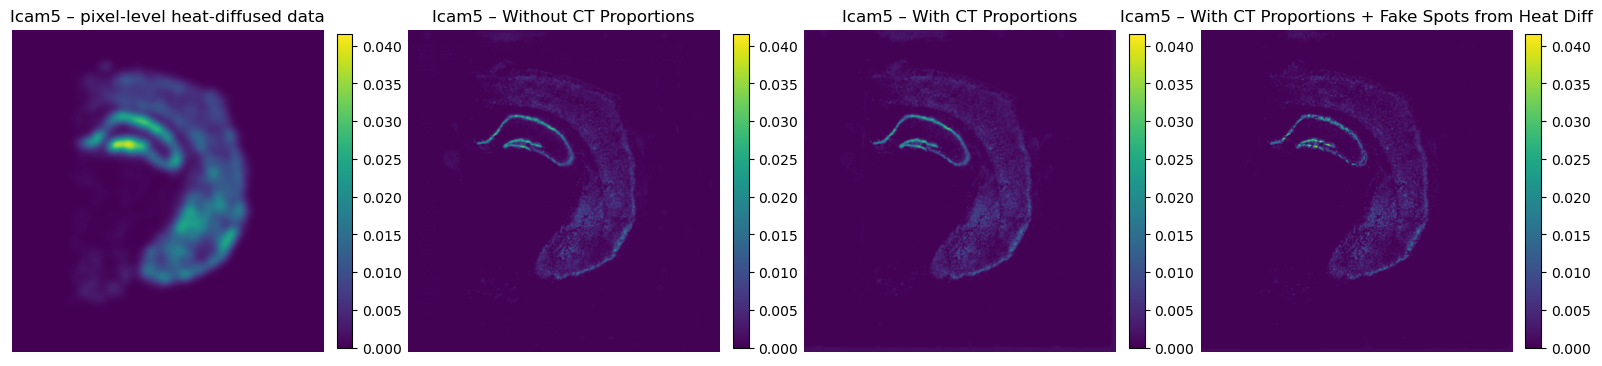

In [10]:
plot_with_contours_multi("Icam5", frac=confident_frac)

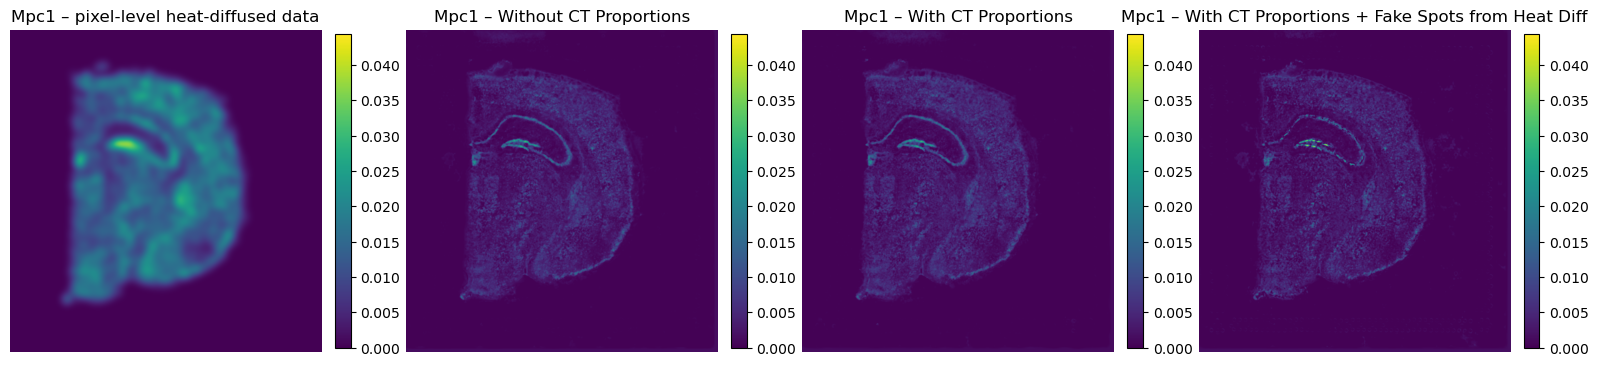

In [16]:
plot_with_contours_multi("Mpc1", frac=confident_frac)

In [17]:
def plot_pixel_boxplots_multi(gene, frac=0.3, drop_zeros=True, log1p=False):
    """
    For a given gene, plot per-pixel expression distributions as box plots
    for:
      - heat-diffused ground truth
      - each model's prediction

    Parameters
    ----------
    gene : str
        Gene name.
    frac : float, optional
        Kept for API symmetry with plot_with_contours_multi (unused here).
    drop_zeros : bool, default True
        If True, drop pixels with value == 0 before plotting.
    log1p : bool, default False
        If True, apply np.log1p to values before plotting.
    """
    # Heat-diffused map
    idx = gene_to_idx[gene]
    heat_map = ge_pixel_maps[:, :, idx]

    # Load model outputs (only those that have pickles for this gene)
    model_maps = []
    valid_cfgs = []
    for cfg in model_configs:
        try:
            arr = load_model_gene(cfg["pickle_dir"], gene)
            model_maps.append(arr)
            valid_cfgs.append(cfg)
        except FileNotFoundError:
            continue

    if not model_maps:
        print(f"{gene}: no model pickle found in any folder.")
        return

    data = []
    labels = []

    # Helper to process a map
    def process_map(arr):
        vals = arr[np.isfinite(arr)].ravel()
        if drop_zeros:
            vals = vals[vals != 0]
        if vals.size == 0:
            return None
        if log1p:
            vals = np.log1p(vals)
        return vals

    # Heat-diffused distribution
    heat_vals = process_map(heat_map)
    if heat_vals is not None:
        data.append(heat_vals)
        labels.append("Heat-diffused")

    # Model distributions
    for cfg, model_map in zip(valid_cfgs, model_maps):
        vals = process_map(model_map)
        if vals is None:
            print(f"Warning: {gene}, model {cfg['display_name']} has no valid pixels, skipping.")
            continue
        data.append(vals)
        labels.append(cfg["display_name"])

    if not data:
        print(f"{gene}: no valid data to plot.")
        return

    plt.figure(figsize=(1.5 * len(data) + 3, 6))
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.ylabel("Pixel-level expression" + (" (log1p)" if log1p else ""))
    plt.title(f"Per-pixel expression distributions for {gene}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


/scratch/ipykernel_2214291/2339077594.py:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


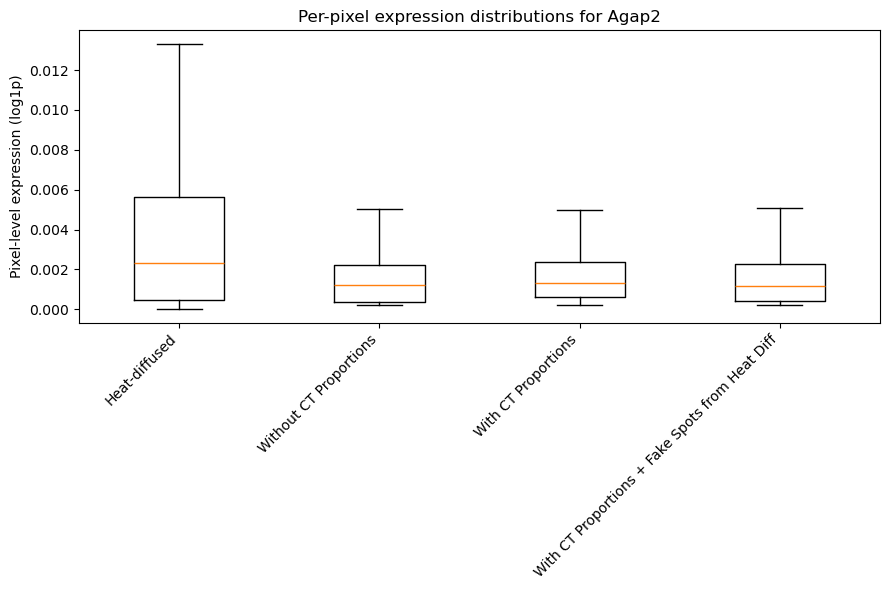

In [18]:
plot_pixel_boxplots_multi("Agap2", drop_zeros=True, log1p=True)


In [19]:
def plot_pixel_boxplots_aggregated(
    genes=None,
    drop_zeros=True,
    log1p=False,
    max_points_per_source=100_000,
):
    """
    Aggregate pixel-level expression across genes and plot distributions
    as box plots for:
      - heat-diffused ground truth
      - each model's prediction

    Parameters
    ----------
    genes : list[str] or None
        Genes to include. If None, use all genes in gene_to_idx.
    drop_zeros : bool, default True
        If True, drop pixels with value == 0 before plotting.
    log1p : bool, default False
        If True, apply np.log1p to values before plotting.
    max_points_per_source : int or None, default 100_000
        If not None, subsample up to this many pixels per source
        to avoid huge memory usage.
    """
    if genes is None:
        genes = list(gene_to_idx.keys())

    # Helper to process a map into a 1D vector of values
    def process_map(arr):
        vals = arr[np.isfinite(arr)].ravel()
        if drop_zeros:
            vals = vals[vals != 0]
        if vals.size == 0:
            return None
        if log1p:
            vals = np.log1p(vals)
        return vals

    # Collect values per source
    source_to_vals = {}
    source_to_vals["Heat-diffused"] = []

    # Pre-allocate model sources
    for cfg in model_configs:
        source_to_vals[cfg["display_name"]] = []

    for gene in genes:
        if gene not in gene_to_idx:
            print(f"Warning: {gene} not in gene_to_idx, skipping.")
            continue

        idx = gene_to_idx[gene]
        heat_map = ge_pixel_maps[:, :, idx]

        # Heat-diffused
        heat_vals = process_map(heat_map)
        if heat_vals is not None:
            source_to_vals["Heat-diffused"].append(heat_vals)

        # Models
        for cfg in model_configs:
            try:
                model_map = load_model_gene(cfg["pickle_dir"], gene)
            except FileNotFoundError:
                # This model has no prediction for this gene; skip
                continue

            vals = process_map(model_map)
            if vals is not None:
                source_to_vals[cfg["display_name"]].append(vals)

    # Build data & labels for plotting
    data = []
    labels = []

    for name, chunks in source_to_vals.items():
        if not chunks:
            continue
        vals = np.concatenate(chunks)

        # Optional subsampling to keep plot manageable
        if (max_points_per_source is not None) and (vals.size > max_points_per_source):
            idx = np.random.choice(vals.size, size=max_points_per_source, replace=False)
            vals = vals[idx]

        data.append(vals)
        labels.append(name)

    if not data:
        print("No valid data to plot.")
        return

    plt.figure(figsize=(1.5 * len(data) + 3, 6))
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.ylabel("Pixel-level expression" + (" (log1p)" if log1p else ""))
    plt.title("Aggregated per-pixel expression distributions across genes")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


/scratch/ipykernel_2214291/3634272873.py:94: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


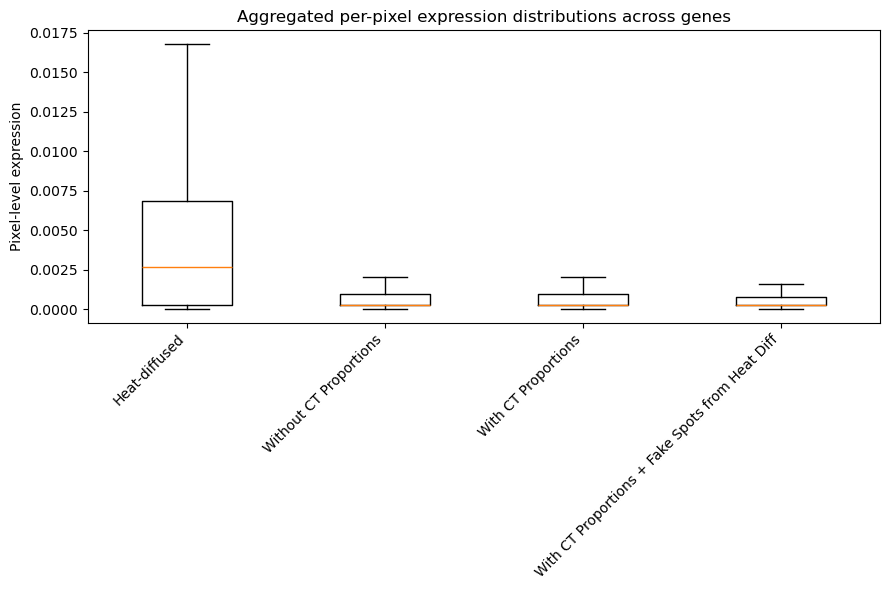

In [20]:
plot_pixel_boxplots_aggregated(max_points_per_source = None)